#  NMF analysis

In [1]:
import os
import itertools

import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2
from fruitfly_parkinson import settings as s
from fruitfly_parkinson.data import get_fly_data, generate_vectors
from fruitfly_parkinson.utils import get_directory
from fruitfly_parkinson.transformers import *
from fruitfly_parkinson.visualisation import plot_fly_data, plot_vec

## Config

In [3]:
behavior = 'ToSleepVector_aggregated'
smoothing_sigma = 5
nb_components = 5

## Load metadata

The experiments which should be analyzed are described in a metadata file.

In [4]:
#df_meta = pd.read_csv(s.DATA_DIR / 'metadata_ID0082_84_85_86_pdfKO.csv', index_col=1)
df_meta = pd.read_csv(s.DATA_DIR / 'metadata_ID0181_182_183.csv', index_col=1)

# strip number from ID
df_meta["experiment_id"] = df_meta["ID"].map(lambda x: int(x.lstrip('ID')))
# drop columns with all NaN's
df_meta = df_meta.dropna(axis=1, how='all')

print("Number of experiments: {}".format(len(df_meta.ID.unique())))
print("Number of flies: {}".format(len(df_meta)))
df_meta.head()

Number of experiments: 3
Number of flies: 430


,ID,machine_name,date,reference_hour,region_id,status,genotype,background,control_genotype,age,sex,food,fly_no,replicate,Temperature,incubator,experiment_id
1,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,1,OK,Park KO,w1118,True,1-5 days old,M,fly food,1,1,25,1,181
2,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,2,OK,Park KO,w1118,True,1-5 days old,M,fly food,2,1,25,1,181
3,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,3,OK,Park KO,w1118,True,1-5 days old,M,fly food,3,1,25,1,181
4,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,4,OK,Park KO,w1118,True,1-5 days old,M,fly food,4,1,25,1,181
5,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,5,OK,Park KO,w1118,True,1-5 days old,M,fly food,5,1,25,1,181


## NMF

In [5]:
# 1 - Load data
df_vec = []
df_vec_meta = []
for _, exp in df_meta.iterrows():
    if exp.status == 'OK':
        directory = get_directory(s.DATA_TRANSFORMED, exp.experiment_id, exp.machine_name, exp.region_id)
        try:
            df_vec_exp = pd.read_csv(os.path.join(directory, f'{behavior}.csv'), index_col=0)
            df_vec.append(df_vec_exp)
            for _ in range(len(df_vec_exp.columns)):
                df_vec_meta.append(exp)
        except FileNotFoundError:
            print(f'Not found: {directory}')
df_vec = pd.concat(df_vec, axis=1)
df_vec_meta = pd.concat(df_vec_meta, axis=1).T
assert len(df_vec.columns) == len(df_vec_meta)

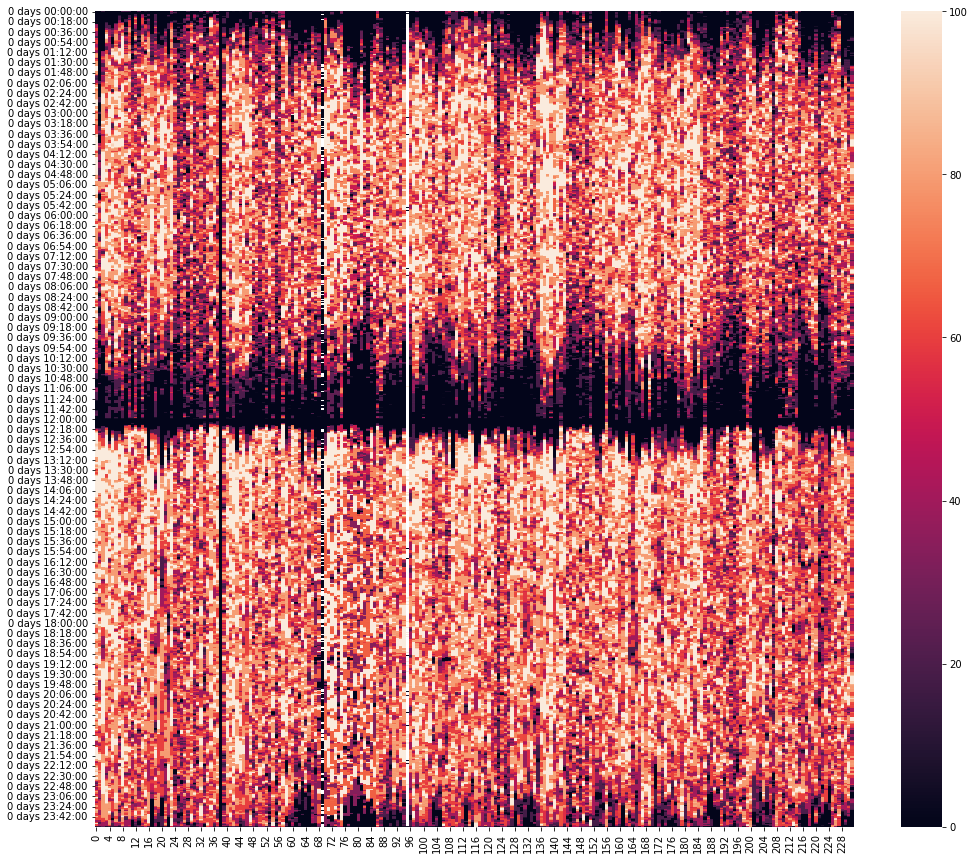

In [6]:
df_vec.columns = range(len(df_vec.columns))
fig, ax = plt.subplots(figsize=(17, 15))
sns.heatmap(df_vec, robust=True);

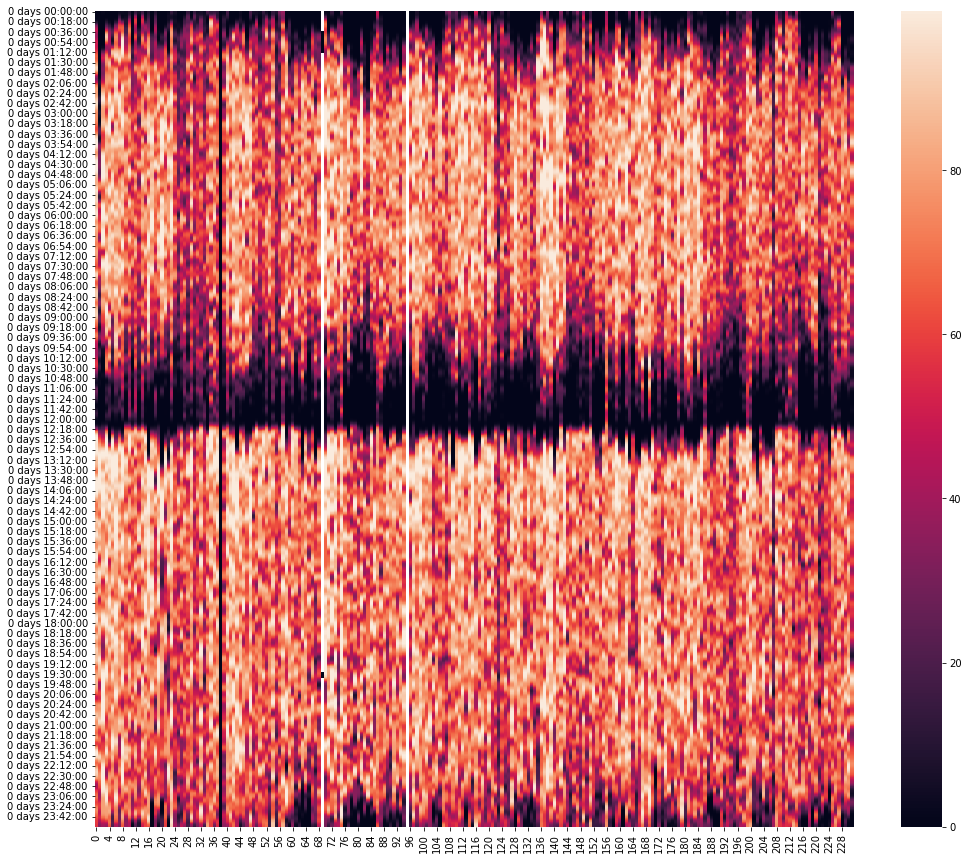

In [7]:
from fruitfly_parkinson.nmf import _smooth

# 2 - Smooth
heatmap = pd.DataFrame(data=_smooth(df_vec, 'gaussian', sigma=[smoothing_sigma,0]), index=df_vec.index)
fig, ax = plt.subplots(figsize=(17, 15))
sns.heatmap(heatmap, robust=True);
#fig.savefig(f'../results/{behavior}_heatmap.png')

In [8]:
from fruitfly_parkinson.nmf import NMFVectorizer

# 3 - NMF
model = joblib.load(os.path.join(s.MODEL_DIR, f'{behavior}_{nb_components}c_model.gz'))
mx = np.ma.masked_invalid(heatmap)
W = model.transform(mx);

## Analysis

In [10]:
df_components = pd.DataFrame(
    data=W.T, 
    index=df_vec_meta.index, 
    columns=[f'component_{i}' for i in range(model.n_components)])
df_cluster = pd.DataFrame(
    data=np.argmax(W, axis=0), 
    index=df_vec_meta.index, 
    columns=[f'cluster'])
df = df_meta.join(df_components).join(df_cluster)

df.head()

,ID,machine_name,date,reference_hour,region_id,status,genotype,background,control_genotype,age,sex,food,fly_no,replicate,Temperature,incubator,experiment_id,component_0,component_1,component_2,component_3,component_4,cluster
1,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,1,OK,Park KO,w1118,True,1-5 days old,M,fly food,1,1,25,1,181,2.859525,1.117884e+00,6.220157,3.578877,6.300198,4.0
2,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,2,OK,Park KO,w1118,True,1-5 days old,M,fly food,2,1,25,1,181,0.000000,2.098855e-10,1.303728,5.256709,5.366872,4.0
3,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,3,OK,Park KO,w1118,True,1-5 days old,M,fly food,3,1,25,1,181,0.291529,4.856436e+00,1.061600,4.483898,3.464234,1.0
4,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,4,OK,Park KO,w1118,True,1-5 days old,M,fly food,4,1,25,1,181,3.323479,4.672115e-01,7.324863,4.073003,6.488026,2.0
5,ID0181,ETHOSCOPE_PV_03,2025-07-03,8,5,OK,Park KO,w1118,True,1-5 days old,M,fly food,5,1,25,1,181,2.584825,3.347271e+00,6.721490,3.599593,2.750077,2.0


/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/fruitfly_parkinson/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


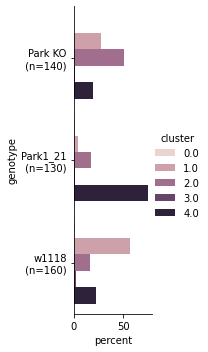

In [11]:
order = df.genotype.unique()
g = (df
.groupby('genotype')['cluster']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), y='genotype',x='percent',hue='cluster',kind='bar', height=5, aspect=.5, row_order=order))

ylabels = [f'{t}\n (n={df.groupby("genotype").size().loc[t]})' for t in order]
g.set(yticklabels=ylabels)
plt.show()

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/fruitfly_parkinson/.venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/boxplot.py:394: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


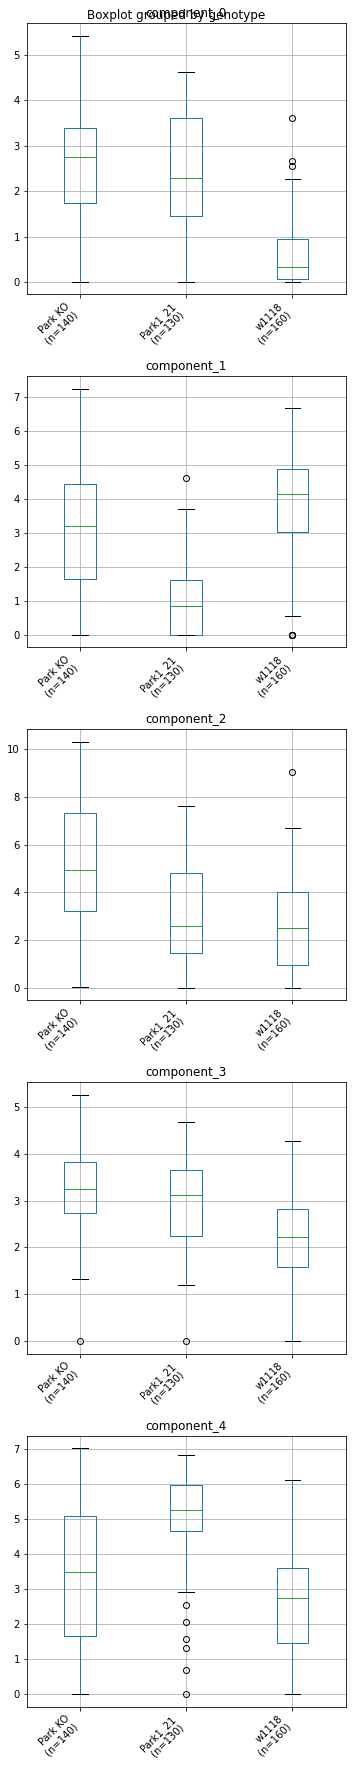

In [12]:
fig, ax = plt.subplots(nrows=model.n_components,figsize=(5, model.n_components*5))
df.boxplot([f'component_{i}' for i in range(model.n_components)], by='genotype', ax=ax)
for axis in ax:
    xlabels = [f'{t.get_text()}\n (n={df.groupby("genotype").size().loc[t.get_text()]})' for t in axis.get_xticklabels()]
    axis.set_xticklabels(xlabels, rotation=45, ha='right')
    axis.xaxis.label.set_visible(False)
plt.tight_layout()